In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Load data
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

def reformat_data(df):
    df['Month'] = pd.to_datetime(df['Month'], format='%m-%d-%Y')
    df.set_index('Month', inplace=True)
    return df

def preprocess_data(df):
    """Preprocess the data with advanced techniques."""
    # Handle zeros and missing values
    df['Avg_sunspot_count'] = df['Avg_sunspot_count'].replace(0, 0.01)
    df['Avg_sunspot_count'] = pd.to_numeric(df['Avg_sunspot_count'], errors='coerce')
    
    # Apply log transformation to stabilize variance
    df['log_sunspot'] = np.log1p(df['Avg_sunspot_count'])
    
    return df

def fit_multiple_smoothing(df):
    """Apply multiple smoothing techniques."""
    # Additive smoothing
    model_add = ExponentialSmoothing(
        df['Avg_sunspot_count'],
        trend="add",
        seasonal="add",
        seasonal_periods=12,
        damped_trend=True
    ).fit()
    
    # Multiplicative smoothing
    model_mul = ExponentialSmoothing(
        df['Avg_sunspot_count'],
        trend="mul",
        seasonal="mul",
        seasonal_periods=12,
        damped_trend=True
    ).fit()
    
    df['smoothed_add'] = model_add.fittedvalues
    df['smoothed_mul'] = model_mul.fittedvalues
    
    # Combine smoothing results
    df['smoothed_combined'] = 0.5 * (df['smoothed_add'] + df['smoothed_mul'])
    
    return df, model_add, model_mul

def find_best_arima_params(data, max_p=5, max_d=2, max_q=5):
    """Find optimal ARIMA parameters."""
    best_aic = float('inf')
    best_params = None
    
    for p in range(max_p):
        for d in range(max_d):
            for q in range(max_q):
                try:
                    model = ARIMA(data, order=(p, d, q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_params = (p, d, q)
                except:
                    continue
    
    return best_params

In [3]:
df = load_data('data/train.csv')
df.head()

,Month,Avg_sunspot_count
0,01-01-1749,97
1,02-01-1749,104
2,03-01-1749,117
3,04-01-1749,93
4,05-01-1749,142


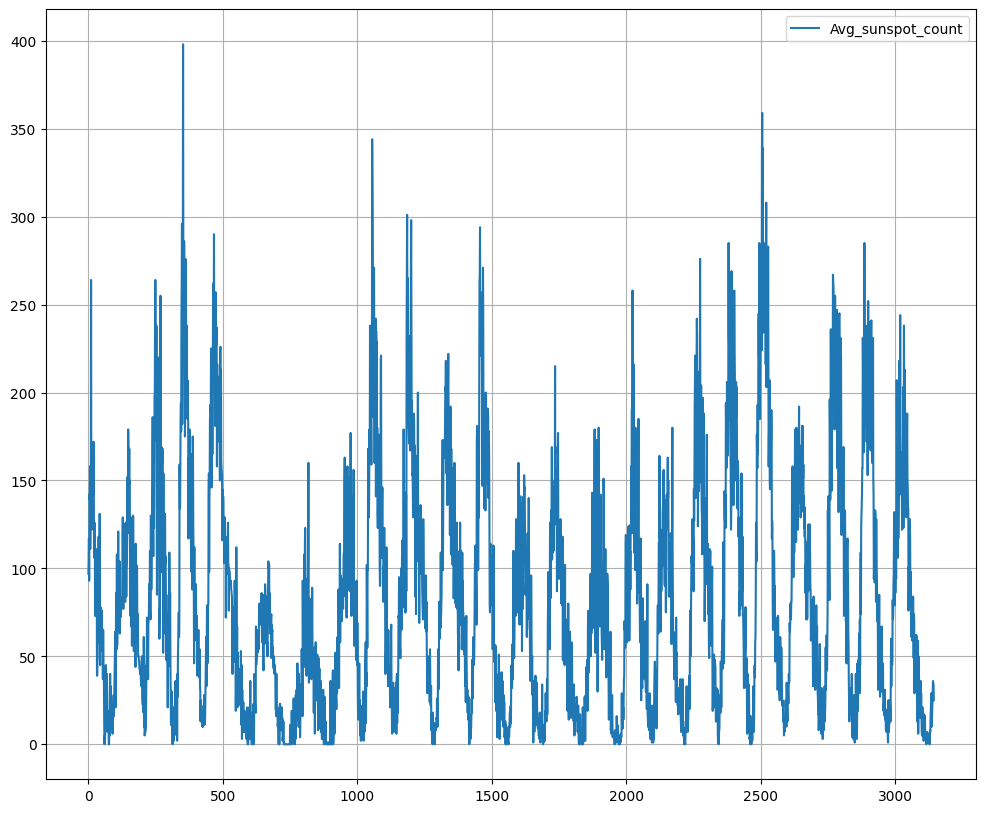

In [4]:
# Plot original data
df.plot(figsize=(12, 10), grid=True)
plt.show()

In [5]:
df = reformat_data(df)
df = preprocess_data(df)
df.head()

,Avg_sunspot_count,log_sunspot
Month,,
1749-01-01,97.0,4.584967
1749-02-01,104.0,4.653960
1749-03-01,117.0,4.770685
1749-04-01,93.0,4.543295
1749-05-01,142.0,4.962845


In [6]:
# Apply multiple smoothing
df, model_add, model_mul = fit_multiple_smoothing(df)

In [7]:
# Split data
train_end = datetime(1990, 12, 31)
test_end = datetime(2010, 12, 31)
train = df[:train_end]
test = df[train_end + timedelta(days=1):test_end]

In [8]:
# Find best ARIMA parameters for both original and smoothed series
best_params_orig = find_best_arima_params(train['Avg_sunspot_count'])
best_params_smooth = find_best_arima_params(train['smoothed_combined'])

In [9]:
# Fit ARIMA models
model_orig = ARIMA(train['Avg_sunspot_count'], order=best_params_orig).fit()
model_smooth = ARIMA(train['smoothed_combined'], order=best_params_smooth).fit()

In [10]:
# Generate forecasts
forecast_orig = model_orig.forecast(steps=len(test))
forecast_smooth = model_smooth.forecast(steps=len(test))

In [11]:
# Combine forecasts with weighted average
forecast_combined = 0.7 * forecast_orig + 0.3 * forecast_smooth

In [12]:
# Calculate metrics
rmse = np.sqrt(mean_squared_error(test['Avg_sunspot_count'], forecast_combined))
print(f"RMSE: {rmse}")

RMSE: 69.02214862100611


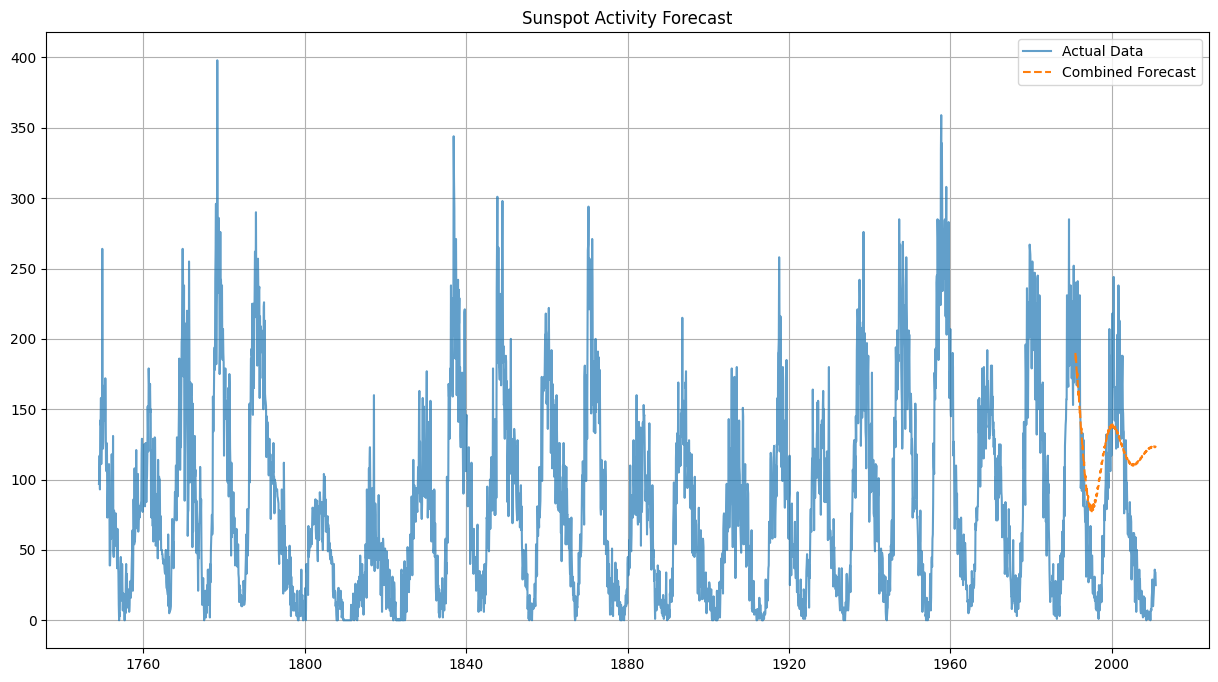

In [13]:
# Plot results
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['Avg_sunspot_count'], label='Actual Data', alpha=0.7)
plt.plot(test.index, forecast_combined, label='Combined Forecast', linestyle='--')
plt.title('Sunspot Activity Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Generate final forecast for submission
final_model_orig = ARIMA(df['Avg_sunspot_count'], order=best_params_orig).fit()
final_model_smooth = ARIMA(df['smoothed_combined'], order=best_params_smooth).fit()

In [15]:
sample_submission = pd.read_csv('data/test.csv')
final_forecast_orig = final_model_orig.forecast(steps=len(sample_submission))
final_forecast_smooth = final_model_smooth.forecast(steps=len(sample_submission))
final_forecast = 0.4 * final_forecast_orig + 0.6 * final_forecast_smooth

# Create submission file
final_submission = sample_submission[['Month']].copy()
final_submission['Avg_sunspot_count'] = final_forecast
final_submission.to_csv('improved_sunspot_forecast_arima.csv', index=False)